In [17]:
import numpy as np 
import SimpleITK as sitk 
import matplotlib.pyplot as plt 
from library_dicom.dicom_processor.tools.create_mip import *

In [138]:
ct_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/51011102171008/pet0/1.2.276.0.7230010.3.2.301136_nifti_CT.nii'
pet_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/51011102171008/pet0/1.2.276.0.7230010.3.2.301136_nifti_PT.nii' 
mask_path =  '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/51011102171008/pet0/1.2.276.0.7230010.3.2.301136_nifti_mask.nii'

In [139]:
#read nifti 

img_ct = sitk.ReadImage(ct_path)
img_pt = sitk.ReadImage(pet_path)
img_mask = sitk.ReadImage(mask_path)

ct_array = sitk.GetArrayFromImage(img_ct).transpose()
pet_array = sitk.GetArrayFromImage(img_pt).transpose()
mask_array = sitk.GetArrayFromImage(img_mask).transpose()

print("taille ct : ", ct_array.shape)
print("taille pet : ", pet_array.shape)
print("taille mask : ", mask_array.shape)

taille ct :  (512, 512, 349)
taille pet :  (168, 168, 287)
taille mask :  (168, 168, 287, 5)


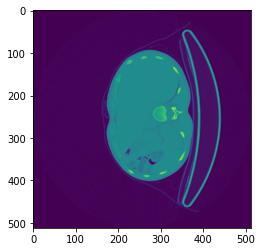

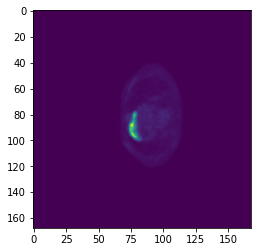

In [38]:
plt.imshow(ct_array[:,:,200])
plt.show()
plt.imshow(pet_array[:,:,200])
plt.show()

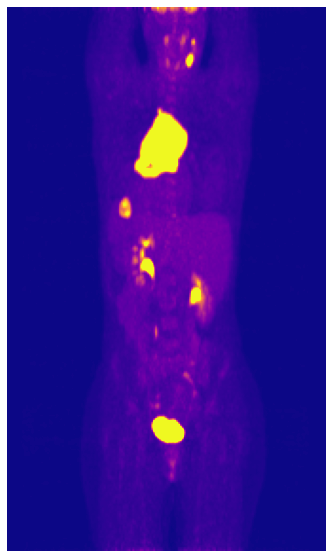

In [47]:
mip_imshow(pet_array, 90, cmap='plasma', type='pet', vmin=0, vmax=8)

(168, 168, 287)


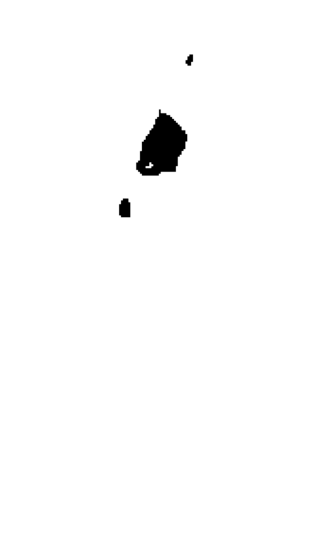

In [71]:
#treshold mask : 
from library_dicom.dicom_processor.tools.threshold_mask import *

mask_array_tresh = get_threshold_matrix_4D(mask_array, pet_array, 0.41)
mask_sum = np.sum(mask_array_tresh, axis = -1)
mask_sum[np.where(mask_sum > 1)] = 1
print(mask_sum.shape)

mip_imshow(mask_sum, 90, cmap='Greys', type='mask', vmin=0, vmax=10)

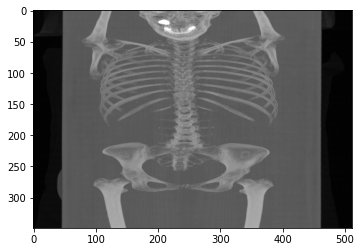

In [42]:
plt.imshow(np.rot90(np.amax(ct_array, axis = 1)), cmap = 'gray')

In [52]:
#ct transformation 
print(img_pt.GetSize())
print(img_pt.GetOrigin())
print(img_pt.GetSpacing())
print(img_pt.GetDirection())

transformation = sitk.ResampleImageFilter()
transformation.SetOutputDirection(img_pt.GetDirection())
transformation.SetOutputOrigin(img_pt.GetOrigin())
transformation.SetSize(img_pt.GetSize())
transformation.SetOutputSpacing(img_pt.GetSpacing())
transformation.SetInterpolator(sitk.sitkBSpline)

new_ct = transformation.Execute(img_ct)

(168, 168, 287)
(-340.08990478515625, -471.54327392578125, -1781.5)
(4.062709808349609, 4.062709808349609, 3.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


In [54]:
new_array_ct = sitk.GetArrayFromImage(new_ct).transpose()
new_array_ct.shape

(168, 168, 287)

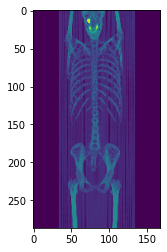

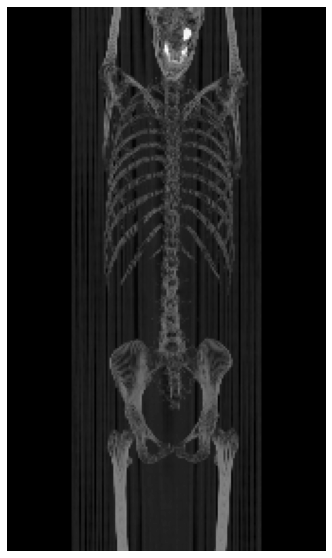

In [63]:
plt.imshow(np.rot90(np.amax(new_array_ct, axis = 1)))
mip_imshow(new_array_ct, 90, cmap='gray', type='mask', vmin=None, vmax=None)

In [ ]:
#mask avec seuil à 41% 

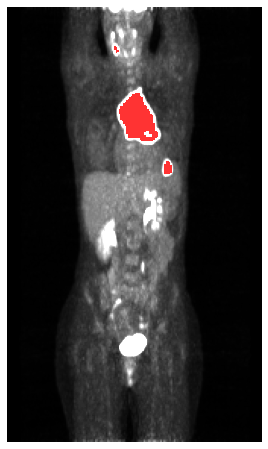

In [122]:
f = plt.figure(figsize=(8,8))
axes = plt.gca()
axes.set_axis_off()
#plt.imshow(np.rot90(np.amax(new_array_ct, axis = 1)), cmap  = 'gray', alpha=0.5)
plt.imshow(np.rot90(np.amax(pet_array, axis = 1)), cmap  = 'gray', vmin= 0, vmax=3)
plt.imshow(np.where(np.rot90(np.amax(mask_sum, axis = 1)), 0, np.nan ), cmap  = 'hsv', alpha=0.8)

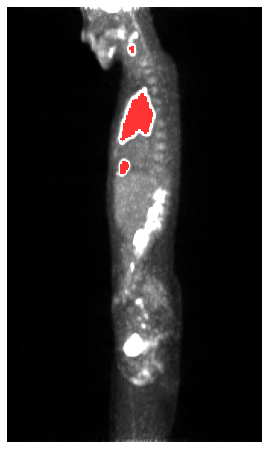

In [123]:
f = plt.figure(figsize=(8,8))
axes = plt.gca()
axes.set_axis_off()
#plt.imshow(np.rot90(np.amax(new_array_ct, axis = 1)), cmap  = 'gray', alpha=0.5)
plt.imshow(np.rot90(np.amax(pet_array, axis = 0)), cmap  = 'gray', vmin= 0, vmax=3)
plt.imshow(np.where(np.rot90(np.amax(mask_sum, axis = 0)), 0, np.nan ), cmap  = 'hsv', alpha=0.8)

In [144]:
#mask avec seuil à 2.5 

mask_2_5 = np.copy(mask_array)
mask_2_5[np.where(pet_array < 2.5)] = 0
mask_2_5 = np.sum(mask_2_5, axis = -1)
mask_2_5[np.where(mask_2_5 > 1)] = 1
print(mask_2_5.shape)


(168, 168, 287)


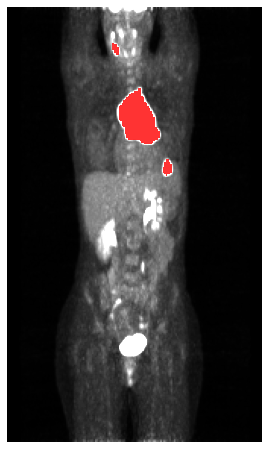

In [145]:
f = plt.figure(figsize=(8,8))
axes = plt.gca()
axes.set_axis_off()
#plt.imshow(np.rot90(np.amax(new_array_ct, axis = 1)), cmap  = 'gray', alpha=0.5)
plt.imshow(np.rot90(np.amax(pet_array, axis = 1)), cmap  = 'gray', vmin= 0, vmax=3)
plt.imshow(np.where(np.rot90(np.amax(mask_2_5, axis = 1)), 0, np.nan ), cmap  = 'hsv', alpha=0.8)

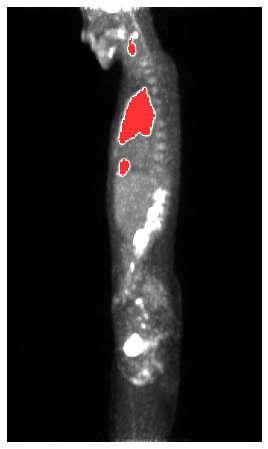

In [146]:
f = plt.figure(figsize=(8,8))
axes = plt.gca()
axes.set_axis_off()
#plt.imshow(np.rot90(np.amax(new_array_ct, axis = 1)), cmap  = 'gray', alpha=0.5)
plt.imshow(np.rot90(np.amax(pet_array, axis = 0)), cmap  = 'gray', vmin= 0, vmax=3)
plt.imshow(np.where(np.rot90(np.amax(mask_2_5, axis = 0)), 0, np.nan ), cmap  = 'hsv', alpha=0.8)

In [148]:
#mask avec seuil à 4

mask_4 = np.copy(mask_array)
mask_4[np.where(pet_array < 4)] = 0
mask_4 = np.sum(mask_4, axis = -1)
mask_4[np.where(mask_4 > 1)] = 1
print(mask_4.shape)

(168, 168, 287)


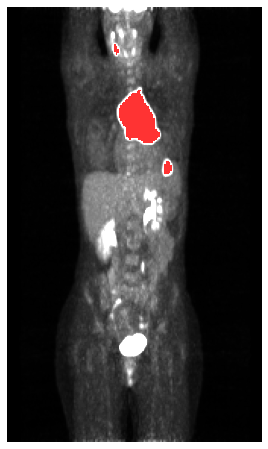

In [149]:
f = plt.figure(figsize=(8,8))
axes = plt.gca()
axes.set_axis_off()
#plt.imshow(np.rot90(np.amax(new_array_ct, axis = 1)), cmap  = 'gray', alpha=0.5)
plt.imshow(np.rot90(np.amax(pet_array, axis = 1)), cmap  = 'gray', vmin= 0, vmax=3)
plt.imshow(np.where(np.rot90(np.amax(mask_4, axis = 1)), 0, np.nan ), cmap  = 'hsv', alpha=0.8)

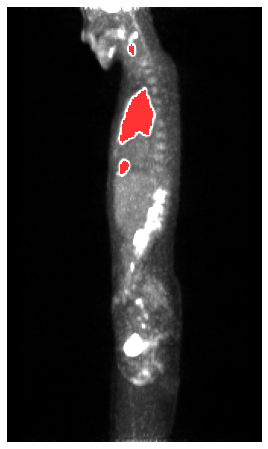

In [150]:
f = plt.figure(figsize=(8,8))
axes = plt.gca()
axes.set_axis_off()
#plt.imshow(np.rot90(np.amax(new_array_ct, axis = 1)), cmap  = 'gray', alpha=0.5)
plt.imshow(np.rot90(np.amax(pet_array, axis = 0)), cmap  = 'gray', vmin= 0, vmax=3)
plt.imshow(np.where(np.rot90(np.amax(mask_4, axis = 0)), 0, np.nan ), cmap  = 'hsv', alpha=0.8)

In [ ]:
#inference 

In [152]:
inference_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/train/1.2.276.0.7230010.3.2.301136_mask_pred_float.nii'

inf_img = sitk.ReadImage(inference_path)
inf_array = sitk.GetArrayFromImage(inf_img).transpose()

inf_array[np.where(inf_array <= 0.5)] = 0
inf_array[np.where(inf_array >= 0.5)] = 1


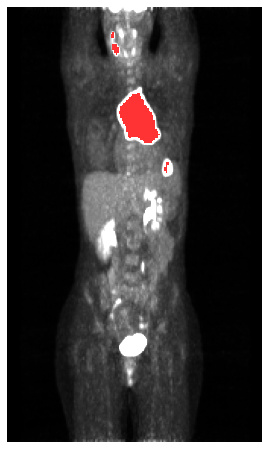

In [153]:
f = plt.figure(figsize=(8,8))
axes = plt.gca()
axes.set_axis_off()
#plt.imshow(np.rot90(np.amax(new_array_ct, axis = 1)), cmap  = 'gray', alpha=0.5)
plt.imshow(np.rot90(np.amax(pet_array, axis = 1)), cmap  = 'gray', vmin= 0, vmax=3)
plt.imshow(np.where(np.rot90(np.amax(inf_array, axis = 1)), 0, np.nan ), cmap  = 'hsv', alpha=0.8)

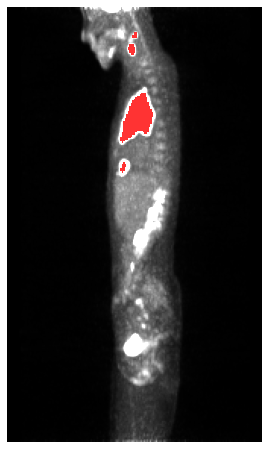

In [154]:
f = plt.figure(figsize=(8,8))
axes = plt.gca()
axes.set_axis_off()
#plt.imshow(np.rot90(np.amax(new_array_ct, axis = 1)), cmap  = 'gray', alpha=0.5)
plt.imshow(np.rot90(np.amax(pet_array, axis = 0)), cmap  = 'gray', vmin= 0, vmax=3)
plt.imshow(np.where(np.rot90(np.amax(inf_array, axis = 0)), 0, np.nan ), cmap  = 'hsv', alpha=0.8)